# Deep Learning Stress Prediction – Wide & Deep Model

Notebook ini menggunakan **deep learning murni** (tanpa XGBoost/RandomForest) dengan arsitektur **Wide & Deep**:
- MLP dalam untuk fitur numerik
- Embedding untuk fitur kategorikal (`department` dan `employee_id`)
- Target akurasi: **setinggi mungkin** dengan dataset apa adanya (tanpa mengubah file CSV)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization,
    Embedding, Flatten, Concatenate
)
from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)

# SESUAIKAN PATH INI DENGAN LOKASI FILE DI KOMPUTER ANDA
# jika file ada di folder yang sama dengan notebook, cukup pakai:
# df = pd.read_csv('dataset_prediksi_stres_1000_balanced.csv')
df = pd.read_csv('dataset_prediksi_stres_1000_balanced.csv')

df.head()

2025-11-23 15:49:37.126521: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-23 15:49:37.228951: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-23 15:49:39.420571: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


2.20.0


,employee_id,department,workload,work_life_balance,team_conflict,management_support,work_environment,stress_level,label
0,EMP_SYN_1_0120,Operations,3,4,4,0,7,30,1
1,EMP_SYN_2_0127,IT,10,4,6,7,10,60,2
2,EMP_SYN_0_0209,Finance,10,10,3,8,0,20,0
3,EMP_SYN_0_0309,Marketing,0,3,5,5,6,17,0
4,EMP_SYN_2_0074,HR,4,7,3,4,2,49,2


## Membuat Label Kelas (Low / Medium / High) dari `stress_level`

In [2]:
def classify(x):
    if x <= 20:
        return 0  # Low
    elif x <= 40:
        return 1  # Medium
    else:
        return 2  # High

df['label'] = df['stress_level'].apply(classify)
df['label'].value_counts()

label
1    333
2    333
0    333
Name: count, dtype: int64

## Preprocessing: Fitur Numerik + Embedding untuk Fitur Kategorikal

In [3]:
numeric_features = ['workload','work_life_balance','team_conflict','management_support','work_environment']

X_num = df[numeric_features].values
y = df['label'].values

# Encode categorical features untuk embedding
le_dept = LabelEncoder()
df['dept_idx'] = le_dept.fit_transform(df['department'])

le_emp = LabelEncoder()
df['emp_idx'] = le_emp.fit_transform(df['employee_id'])

X_dept = df['dept_idx'].values
X_emp = df['emp_idx'].values

# Scaling numeric
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

X_num_train, X_num_test, X_dept_train, X_dept_test, X_emp_train, X_emp_test, y_train, y_test = train_test_split(
    X_num_scaled, X_dept, X_emp, y, test_size=0.2, random_state=42
)

num_classes = len(np.unique(y))
num_depts = df['dept_idx'].nunique()
num_emps = df['emp_idx'].nunique()

X_num_train.shape, X_dept_train.shape, X_emp_train.shape, y_train.shape

((799, 5), (799,), (799,), (799,))

## Arsitektur Deep Learning: Wide & Deep (Numeric + Embedding Kategorikal)

In [4]:
# Input numerik
num_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x_num = BatchNormalization()(num_input)
x_num = Dense(256, activation='relu')(x_num)
x_num = BatchNormalization()(x_num)
x_num = Dropout(0.35)(x_num)
x_num = Dense(128, activation='relu')(x_num)
x_num = BatchNormalization()(x_num)
x_num = Dropout(0.3)(x_num)

# Input department (embedding)
dept_input = Input(shape=(1,), name='dept_input')
dept_emb = Embedding(input_dim=num_depts, output_dim=8, name='dept_emb')(dept_input)
dept_flat = Flatten()(dept_emb)

# Input employee_id (embedding)
emp_input = Input(shape=(1,), name='emp_input')
emp_emb = Embedding(input_dim=num_emps, output_dim=8, name='emp_emb')(emp_input)
emp_flat = Flatten()(emp_emb)

# Gabungkan semua
concat = Concatenate()([x_num, dept_flat, emp_flat])
x = Dense(128, activation='relu')(concat)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)

output = Dense(num_classes, activation='softmax', name='output')(x)

model = Model(inputs=[num_input, dept_input, emp_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

E0000 00:00:1763887779.926521  458560 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1763887779.935546  458560 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ num_input           │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 5)         │         20 │ num_input[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │      1,536 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dept_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emp_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dept_emb            │ (None, 1, 8)      │         40 │ dept_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emp_emb (Embedding) │ (None, 1, 8)      │      7,992 │ emp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8)         │          0 │ dept_emb[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ emp_emb[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 144)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     18,560 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_3[0][0]   

 Total params: 73,911 (288.71 KB)

 Trainable params: 72,685 (283.93 KB)

 Non-trainable params: 1,226 (4.79 KB)

## Training Model dengan EarlyStopping

In [5]:
es = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    [X_num_train, X_dept_train, X_emp_train],
    y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)

Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.3427 - loss: 1.5098 - val_accuracy: 0.3000 - val_loss: 1.0969
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3615 - loss: 1.3621 - val_accuracy: 0.3750 - val_loss: 1.0945
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3693 - loss: 1.2539 - val_accuracy: 0.3812 - val_loss: 1.0926
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3928 - loss: 1.2595 - val_accuracy: 0.4062 - val_loss: 1.0888
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3756 - loss: 1.1951 - val_accuracy: 0.4125 - val_loss: 1.0851
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3787 - loss: 1.1738 - val_accuracy: 0.3500 - val_loss: 1.0881
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4131 - loss: 1.1596 - val_accuracy: 0.3562 - val_loss: 1.0916
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4225 - loss: 1.1096 - val_accuracy: 0.37

## Plot Kurva Training (Loss & Accuracy)

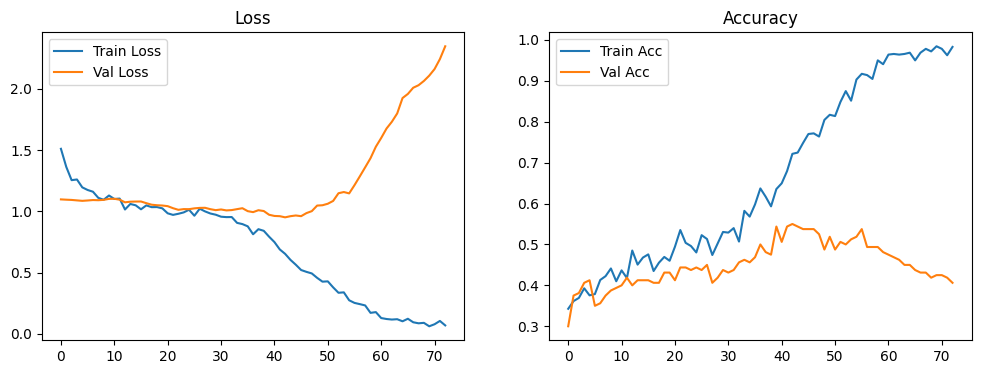

In [6]:
history_dict = history.history

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history_dict['accuracy'], label='Train Acc')
plt.plot(history_dict['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

## Evaluasi di Data Test

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Test Accuracy: 0.57

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.63      0.66        81
           1       0.52      0.52      0.52        63
           2       0.47      0.54      0.50        56

    accuracy                           0.57       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.58      0.57      0.57       200



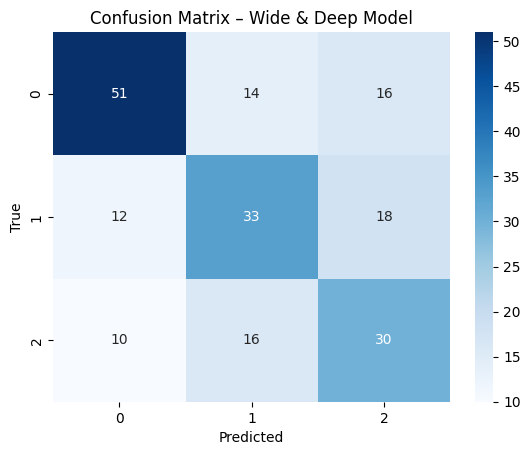

In [7]:
y_proba = model.predict([X_num_test, X_dept_test, X_emp_test])
y_pred = np.argmax(y_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix – Wide & Deep Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()